## Hyperparameter Tunning Notebook

This notebook objective is to tune the models that will be used for the analysis of the price stocks aiming to finalize with higher performance than standards one. 

The models to tune will be added from `models.py` file, that includes 3 classes with:

1. ARIMA
2. Prophet 
3. LSTM neural network
    - 1 LSTM nn
    - 2 stacked LSTM nn
    - 3 stacked LSTM nn
    - 4 stacked LSTM nn
    - Bidirectional LSTM nn.
    
The tune will be processed in that order.

In [1]:
# libraries needed for hyperparameter tunning.
import pandas as pd
import matplotlib.pyplot as plt

from utils.data_preprocessing import download_stocks_from_list, prepare_df, impute_data_points
from utils.model_utils import run_arima_model, run_prophet_model, run_sequential_lstm_model, model_decision

from utils.data.data_config import LIST_DAX_COMPANIES

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


### Data Preparation 

First step is to read and prepare the input data. The functions are imported from `data_preprocessing` file. 

The hyperparameter tuning will be developed with the linear imputation method.

In [2]:
df = prepare_df()

df_imputed_linear = impute_data_points(df, interpolation_method='linear')

In [3]:
df_imputed_linear.describe()

,1COV.DE,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE,CON.DE,DAI.DE,DB1.DE,...,IFX.DE,LIN.DE,MRK.DE,MTX.F,MURGY,RWE.DE,SAP.DE,SIE.DE,VNA.DE,VOW.DE
,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,...,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume
count,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,...,1.311000e+03,1.311000e+03,1.311000e+03,1311.000000,1.311000e+03,1.311000e+03,1.311000e+03,1.311000e+03,1.311000e+03,1311.000000
mean,46.361376,194.696039,160.905193,59.484050,73.502325,91.558810,66.426287,139.608830,48.850128,105.205484,...,5.913759e+06,4.570961e+05,5.119091e+05,686.576659,7.061648e+04,3.972618e+06,2.599842e+06,2.305149e+06,1.420675e+06,94475.192220
std,14.110612,57.671149,29.880097,9.338290,15.879234,9.171365,7.553886,36.849964,7.626227,29.065888,...,3.167616e+06,8.427523e+05,2.366998e+05,1519.819614,1.105311e+05,2.395043e+06,1.591414e+06,1.241589e+06,6.343202e+05,49005.220087
min,20.294693,76.546570,98.523102,34.059311,40.360001,73.293762,35.660213,49.555496,20.560038,60.580975,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,7.100000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,36.026791,159.202858,140.655769,52.814320,59.878864,84.792740,61.638380,110.824215,44.795918,78.585106,...,3.861482e+06,0.000000e+00,3.681635e+05,77.000000,3.210000e+04,2.593597e+06,1.781683e+06,1.592822e+06,1.035612e+06,62442.000000
50%,43.383354,187.431351,164.880005,57.857639,73.847107,92.106804,66.736839,141.710541,49.324951,106.744141,...,5.041887e+06,0.000000e+00,4.581960e+05,220.500000,4.470000e+04,3.429647e+06,2.200325e+06,2.020846e+06,1.289642e+06,84605.000000
75%,56.938112,250.330986,183.401459,67.969803,86.349686,97.681351,72.475639,166.352165,55.046583,132.692017,...,6.962614e+06,7.565430e+05,5.907545e+05,576.500000,6.995000e+04,4.630854e+06,2.890839e+06,2.593110e+06,1.615288e+06,112686.000000
max,78.717293,309.818024,218.202454,78.570663,107.656120,115.493759,82.866203,218.441803,63.200882,169.000000,...,3.116724e+07,1.594435e+07,2.215131e+06,20283.000000,2.571300e+06,3.418952e+07,2.220034e+07,1.214755e+07,5.966401e+06,419225.000000


## 1. Benchmarking - ARIMA model 

In [4]:
def hyperparameter_tunning_arima(df, symbol, p_list, d_list, q_list):
    k, horizon = 8, 5
    end_value_fold = int(len(df[symbol]['Adj Close'].dropna())/k)
    RMSE_error_total = []
    RMSE = []
    for p in p_list:
        for d in d_list:
            for q in q_list:
    
                for current_k in range(k-1):
                    RMSE_error_total.append(run_arima_model(horizon, current_k, end_value_fold, df[symbol].dropna(), 'Adj Close', p, d, q))

                rmse_mean = sum(RMSE_error_total)/(k-1)
                RMSE.append(rmse_mean)
                print(f"- The average RMSE of symbol {symbol} of the CV with {k}-fold with hyperparameters {p}, {d}, {q} is: {rmse_mean}")
                RMSE_error_total = []
                
    return RMSE

In [6]:
cov = hyperparameter_tunning_arima(df_imputed_linear, '1COV.DE', p_list=[x for x in range(2, 16, 2)], d_list=[1], q_list=[0])

- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters 2, 1, 0 is: 1.059404000931205
- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters 4, 1, 0 is: 1.073282395630306
- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters 6, 1, 0 is: 1.085458783835686
- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters 8, 1, 0 is: 1.078245164571292
- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters 10, 1, 0 is: 1.072678156070463
- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters 12, 1, 0 is: 1.0802458934287742
- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters 14, 1, 0 is: 1.082954350460988


In [7]:
ads = hyperparameter_tunning_arima(df_imputed_linear, 'ADS.DE', p_list=[x for x in range(2, 16, 2)], d_list=[1], q_list=[0])

- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters 2, 1, 0 is: 4.5108788628494665
- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters 4, 1, 0 is: 4.577851538374389
- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters 6, 1, 0 is: 4.560390905193605
- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters 8, 1, 0 is: 4.406152861979186
- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters 10, 1, 0 is: 4.468734427562545
- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters 12, 1, 0 is: 4.430335340166816
- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters 14, 1, 0 is: 4.354016123553398


In [8]:
mrk = hyperparameter_tunning_arima(df_imputed_linear, 'MRK.DE', p_list=[x for x in range(2, 16, 2)], d_list=[1], q_list=[0])

- The average RMSE of symbol MRK.DE of the CV with 8-fold with hyperparameters 2, 1, 0 is: 1.2458204837381301
- The average RMSE of symbol MRK.DE of the CV with 8-fold with hyperparameters 4, 1, 0 is: 1.2187474782896466
- The average RMSE of symbol MRK.DE of the CV with 8-fold with hyperparameters 6, 1, 0 is: 1.200981085689698
- The average RMSE of symbol MRK.DE of the CV with 8-fold with hyperparameters 8, 1, 0 is: 1.2278314424366734
- The average RMSE of symbol MRK.DE of the CV with 8-fold with hyperparameters 10, 1, 0 is: 1.2175160429369298
- The average RMSE of symbol MRK.DE of the CV with 8-fold with hyperparameters 12, 1, 0 is: 1.261593003410295
- The average RMSE of symbol MRK.DE of the CV with 8-fold with hyperparameters 14, 1, 0 is: 1.2814208242637584


For the first 3 symbols we don't see a clear **p** that performs better but we can narrow down to a range of [6, 8, 10] in order to find which one is better.

In [5]:
RMSE_arima = {}

for symbol in LIST_DAX_COMPANIES:
    RMSE_arima[symbol] = hyperparameter_tunning_arima(df_imputed_linear, symbol, p_list=[x for x in range(6, 12, 2)], d_list=[1], q_list=[0])
    print('')

- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters 6, 1, 0 is: 1.085458783835686
- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters 8, 1, 0 is: 1.078245164571292
- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters 10, 1, 0 is: 1.072678156070463

- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters 6, 1, 0 is: 4.560390905193605
- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters 8, 1, 0 is: 4.406152861979186
- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters 10, 1, 0 is: 4.468734427562545

- The average RMSE of symbol ALV.DE of the CV with 8-fold with hyperparameters 6, 1, 0 is: 2.617497075565744
- The average RMSE of symbol ALV.DE of the CV with 8-fold with hyperparameters 8, 1, 0 is: 2.7107344690660287
- The average RMSE of symbol ALV.DE of the CV with 8-fold with hyperparameters 10, 1, 0 is: 2.7826155050617105

- The av

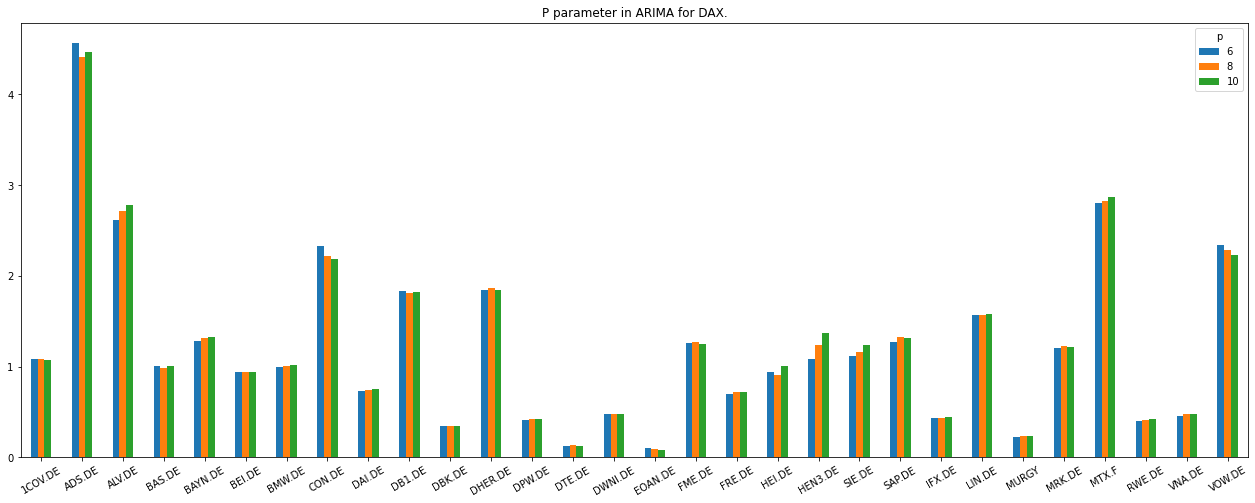

In [6]:
df_rmse_arima = pd.DataFrame(RMSE_arima)
df_rmse_arima['p'] = [6, 8, 10]
df_rmse_arima.set_index('p', inplace=True)
df_rmse_arima = df_rmse_arima.T

df_rmse_arima.plot.bar(rot=30, figsize =(22,8), title="P parameter in ARIMA for DAX.");

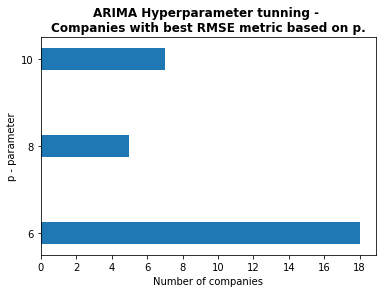

In [11]:
df_rmse_arima['Best Method'] = df_rmse_arima.T.idxmin()

df_rmse_arima['Best Method'].T.value_counts().plot(kind='barh')
plt.title("ARIMA Hyperparameter tunning - \nCompanies with best RMSE metric based on p.", fontweight='bold')
plt.xticks(range(0, 20, 2))
plt.ylabel('p - parameter')
plt.xlabel("Number of companies");

#### Results - ARIMA

The best combination for the 3 analyzed symbols are:
- p = 6
- d = 1
- q = 0

p = 6 was the best for 18 symbols out of 30. That's why we will choose this value for the final parameters of the benchmark model.

## 2. Prophet model 

Prophet will have tunned the daily_seasonality and yearly_seasonality with True or False as possible values. When the value is True, the seasonality is forced. The hyperparameter tunning for prophet will combine those 2 parameters with 4 test.

In [4]:
def hyperparameter_tunning_prophet(df, symbol, daily_seasonality, yearly_sesonality):
    k, horizon = 8, 5
    end_value_fold = int(len(df[symbol]['Adj Close'].dropna())/k)
    RMSE_error_total, RMSE = [], []

    for daily in daily_seasonality:
        for yearly in yearly_sesonality:
            for current_k in range(k-1):
                RMSE_error_total.append(run_prophet_model(horizon, current_k, end_value_fold, df[symbol].dropna(), 'Adj Close', daily, yearly))

            rmse_mean = sum(RMSE_error_total)/(k-1)
            print(f"- The average RMSE of symbol {symbol} of the CV with {k}-fold with hyperparameters daily={daily}, yearly={yearly} is: {rmse_mean}")
            RMSE.append(rmse_mean)
            RMSE_error_total = []
        
    return RMSE


In [13]:
RMSE_prophet = {}

for symbol in LIST_DAX_COMPANIES[:]:
    RMSE_prophet[symbol] = hyperparameter_tunning_prophet(df_imputed_linear, symbol, daily_seasonality=[True, False], yearly_sesonality=[True, False])
    print('')

- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters daily=True, yearly=True is: 3.938092090363407
- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters daily=True, yearly=False is: 4.166519596453656
- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters daily=False, yearly=True is: 3.56347956386555
- The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters daily=False, yearly=False is: 3.797872928079344

- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters daily=True, yearly=True is: 7.727691566891047
- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters daily=True, yearly=False is: 12.22192729327443
- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters daily=False, yearly=True is: 9.448269896402836
- The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters daily=False, yearly=False is: 12.478

- The average RMSE of symbol DAI.DE of the CV with 8-fold with hyperparameters daily=True, yearly=True is: 3.888546971823473
- The average RMSE of symbol DAI.DE of the CV with 8-fold with hyperparameters daily=True, yearly=False is: 2.743127907699796


- The average RMSE of symbol DAI.DE of the CV with 8-fold with hyperparameters daily=False, yearly=True is: 10.182200596174024
- The average RMSE of symbol DAI.DE of the CV with 8-fold with hyperparameters daily=False, yearly=False is: 3.1466897090480717

- The average RMSE of symbol DB1.DE of the CV with 8-fold with hyperparameters daily=True, yearly=True is: 3.165140902803461
- The average RMSE of symbol DB1.DE of the CV with 8-fold with hyperparameters daily=True, yearly=False is: 2.8631218880814404
- The average RMSE of symbol DB1.DE of the CV with 8-fold with hyperparameters daily=False, yearly=True is: 3.173452915492802
- The average RMSE of symbol DB1.DE of the CV with 8-fold with hyperparameters daily=False, yearly=False is: 2.8023784680928876

- The average RMSE of symbol DBK.DE of the CV with 8-fold with hyperparameters daily=True, yearly=True is: 1.0340491602045325
- The average RMSE of symbol DBK.DE of the CV with 8-fold with hyperparameters daily=True, yearly=False is: 1.1

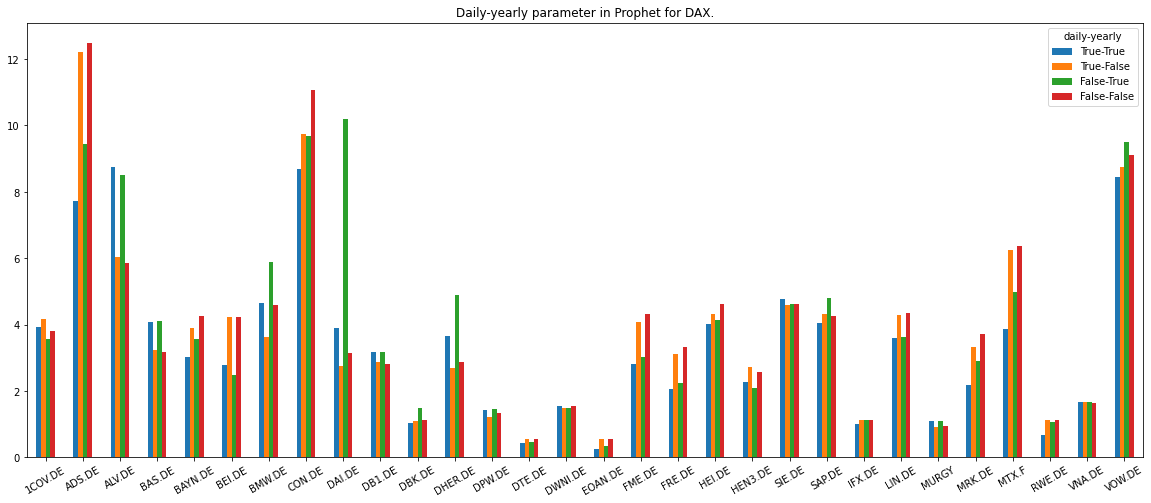

In [14]:
df_rmse_prophet = pd.DataFrame(RMSE_prophet)
df_rmse_prophet['daily-yearly'] = ['True-True', 'True-False', 'False-True', 'False-False']
df_rmse_prophet.set_index('daily-yearly', inplace=True)
df_rmse_prophet = df_rmse_prophet.T

df_rmse_prophet.plot.bar(rot=30, figsize=(20,8), title="Daily-yearly parameter in Prophet for DAX.");

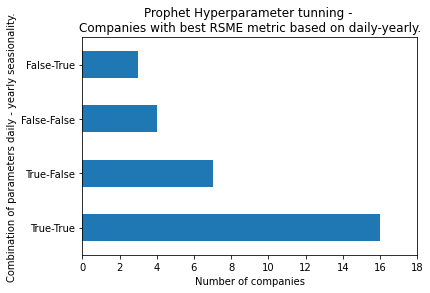

In [15]:
df_rmse_prophet['Best Method'] = df_rmse_prophet.T.idxmin()

df_rmse_prophet['Best Method'].T.value_counts().plot(kind='barh')
plt.title("Prophet Hyperparameter tunning - \nCompanies with best RMSE metric based on daily-yearly.")
plt.xticks(range(0, 20, 2))
plt.ylabel("Combination of parameters daily - yearly seasionality.")
plt.xlabel("Number of companies");

#### Results - Prophet

The best combination for the all the symbols are:
    
- daily_seasonality: True
- yearly_seasonality: True

The combination True-True was the best for 16 symbols out of 30. That's why we will choose this combination of values for the final parameters of the Prophet model.

## 3. LSTM Neural Network model 

The first **parameter** to tune over 3 different symbols (limit number of symbols due to the processing time) will be:

- epochs: [50, 80, 100]

Then we will identify what is the **best model** from:

* LSTM with 1 Layer - LSTM_1
* LSTM with 2 layers - LSTM_2
* LSTM with 3 layers - LSTM_3
* LSTM with 4 layers - LSTM_4
* Bidirection LSTM - LSTM_BI 

After then model is chosen, the **hyperparameters** will be tunned again:

- time_steps: [15, 30, 60]
- units: [40, 50]
- dropout: [0.2, 0.4], if it's needed.


In [5]:
def hyperparameter_tunning_lstm(df, symbol, model_type, time_steps_list, units_list, dropout_list, epochs_list):
    k, horizon = 8, 5
    end_value_fold = int(len(df[symbol]['Adj Close'].dropna())/k)
    RMSE_error_total, RMSE = [], []
    
    for time_steps in time_steps_list:
        for units in units_list:
            for dropout in dropout_list:
                for epochs in epochs_list:
    
                    for current_k in range(k-1):
                        RMSE_error_total.append(run_sequential_lstm_model(horizon, current_k, end_value_fold, df[symbol].dropna(), 'Adj Close', model_type, time_steps, units, dropout, epochs))
                
                    rmse_mean = sum(RMSE_error_total)/(k-1)
                    
                    RMSE.append(rmse_mean)
                    print(f"---> The average RMSE of symbol {symbol} of the CV with {k}-fold with hyperparameters time_steps={time_steps}, units={units}, dropout={dropout}, epochs={epochs} is: {rmse_mean}")
                    RMSE_error_total = []
    return RMSE

In [7]:
# tune the epochs number
model_type = 'LSTM_1'   
LSTM_1_rmse = {}

for symbol in LIST_DAX_COMPANIES:
    LSTM_1_rmse[symbol] = hyperparameter_tunning_lstm(df_imputed_linear, symbol, model_type, time_steps_list=[30], units_list=[50], dropout_list=[0.2], epochs_list=[50, 80, 100])
    print('')

---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=50 is: 3.012201346721901
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=80 is: 2.286923599630612
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=100 is: 2.3454350572418363

---> The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=50 is: 8.752104616061933
---> The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=80 is: 8.193766227983255
---> The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=100 is: 6.669786282477268

---> The average RMSE of symbol ALV.DE of the CV with 8-fold with hyperparameter

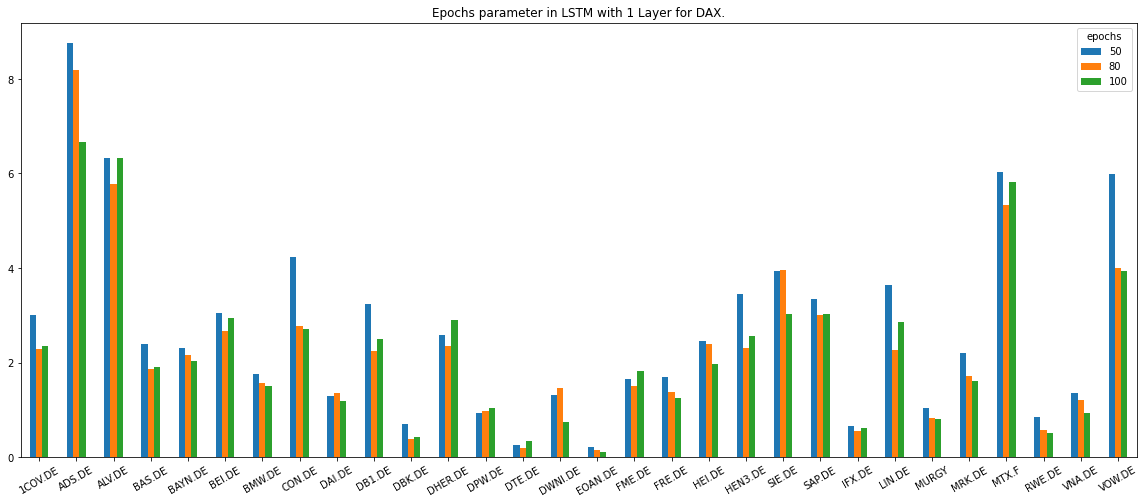

In [8]:
df_rmse_lstm = pd.DataFrame(LSTM_1_rmse)
df_rmse_lstm['epochs'] = [50, 80, 100]
df_rmse_lstm.set_index('epochs', inplace=True)
df_rmse_lstm = df_rmse_lstm.T

df_rmse_lstm.plot.bar(rot=30, figsize=(20,8), title="Epochs parameter in LSTM with 1 Layer for DAX.");

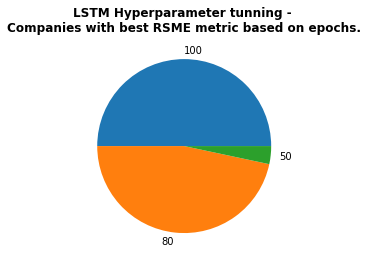

In [12]:
df_rmse_lstm['Best Method'] = df_rmse_lstm.T.idxmin()

df_rmse_lstm['Best Method'].T.value_counts().plot.pie()
plt.title("LSTM Hyperparameter tunning - \nCompanies with best RMSE metric based on epochs.", fontweight='bold')
plt.ylabel("");

In [13]:
# find the best model
model_type_list = ['LSTM_1', 'LSTM_2', 'LSTM_3','LSTM_4', 'LSTM_BI']

for symbol in LIST_DAX_COMPANIES[:1]:
    for model_type in model_type_list:
        print(f'Computing Model {model_type}...')
        hyperparameter_tunning_lstm(df_imputed_linear, symbol, model_type, time_steps_list=[30], units_list=[50], dropout_list=[0.2], epochs_list=[90])
        print('')

Computing Model LSTM_1...
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=90 is: 2.2445380259417225

Computing Model LSTM_2...
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=90 is: 2.2301483888989124

Computing Model LSTM_3...
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=90 is: 2.6128399357219996

Computing Model LSTM_4...
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=90 is: 3.04741701073844

Computing Model LSTM_BI...
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=90 is: 2.135612580873642



In [16]:
# tune the other hyperparamters
model_type = 'LSTM_BI'

LSTM_bi_rmse_time = {}

for symbol in LIST_DAX_COMPANIES[:5]:
    LSTM_bi_rmse_time[symbol] = hyperparameter_tunning_lstm(df_imputed_linear, symbol, model_type, time_steps_list=[15, 30], units_list=[30, 40, 50], dropout_list=[0.2], epochs_list=[90])
    print('')

---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=15, units=30, dropout=0.2, epochs=90 is: 2.1544394388947348
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=15, units=40, dropout=0.2, epochs=90 is: 1.9024277689933577
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=15, units=50, dropout=0.2, epochs=90 is: 2.3713708886176597
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=30, units=30, dropout=0.2, epochs=90 is: 1.782643295323625
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=30, units=40, dropout=0.2, epochs=90 is: 2.201588178104926
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=30, units=50, dropout=0.2, epochs=90 is: 2.843666811545937

---> The average RMSE of symbol ADS.DE of the CV with 8-fold with hyperparamet

In [ ]:
## find best value 

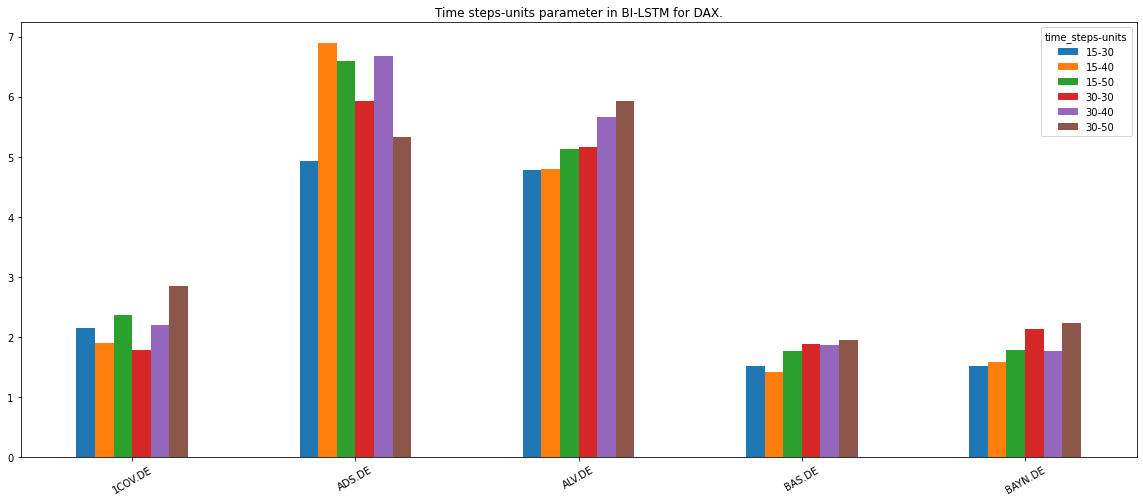

In [17]:
df_bilstm_rmse = pd.DataFrame(LSTM_bi_rmse_time)
df_bilstm_rmse['time_steps-units'] = ['15-30', '15-40', '15-50', '30-30','30-40','30-50']
df_bilstm_rmse.set_index('time_steps-units', inplace=True)
df_bilstm_rmse = df_bilstm_rmse.T

df_bilstm_rmse.plot.bar(rot=30, figsize=(20,8), title="Time steps-units parameter in BI-LSTM for DAX.");

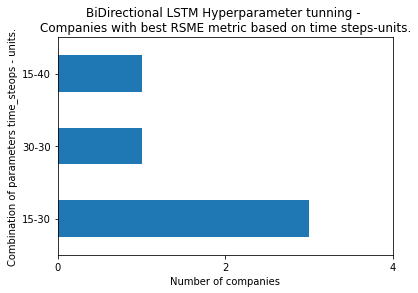

In [21]:
df_bilstm_rmse['Best Method'] = df_bilstm_rmse.T.idxmin()

df_bilstm_rmse['Best Method'].T.value_counts().plot(kind='barh')
plt.title("BiDirectional LSTM Hyperparameter tunning - \nCompanies with best RMSE metric based on time steps-units.")
plt.xticks(range(0, 5, 2))
plt.ylabel("Combination of parameters time_steops - units.")
plt.xlabel("Number of companies");

In [22]:
model_type = 'LSTM_BI'

## Test again the epochs to make sure it was the best also here.
## With the best paramters.

for symbol in LIST_DAX_COMPANIES[0:1]:
    hyperparameter_tunning_lstm(df_imputed_linear, symbol, model_type, time_steps_list=[15], units_list=[30], dropout_list=[0.2], epochs_list=[50, 70, 80, 90, 100])
    print('')

---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=15, units=30, dropout=0.2, epochs=50 is: 2.5147748661244766
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=15, units=30, dropout=0.2, epochs=70 is: 1.9573630440006191
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=15, units=30, dropout=0.2, epochs=80 is: 1.9071442041800233
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=15, units=30, dropout=0.2, epochs=90 is: 1.9815002956485386
---> The average RMSE of symbol 1COV.DE of the CV with 8-fold with hyperparameters time_steps=15, units=30, dropout=0.2, epochs=100 is: 1.7261411049392883



The best parameters for Bi LSTM are:
- time_steps = 15
- units = 30
- epochs=100